## Генератор несуществующих покемонов с помощью реализованной архитектуры DCGAN

### Предварительные настройки

In [33]:
# Установим свежие версии pytorch и других библиотек
!pip install --upgrade pip setuptools wheel --quiet
!pip3 install torch torchvision torchaudio --quiet
!pip install gdown --quiet

In [1]:
import os
import gdown
import torch
import random
import argparse
import numpy as np
import torch.nn as nn
import torch.utils.data
from pathlib import Path
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as ds
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from IPython.display import HTML
import torchvision.transforms as trf
import matplotlib.animation as animation

In [47]:
# Опеределим ключевые переменные

mode = {
    'load_weights': False,
    'train': True,
    'inference': False
}

rd_seed = 21
permute_mask = (1, 2, 0)


ds_url = 'https://drive.google.com/file/d/1TV7Nam3loL-xxrY7EFnXDRKU3RXtgvQx/view?usp=sharing'
data_path = Path('./data/pokemons')

In [97]:
# file */* | grep ' ...x...' -o | sort | less => ±118
im_size = 64


workers = 2

lr = 0.0002
beta1 = 0.5
num_epochs = 5

batch_size = 64

model_params = {
    'latent_sz': 100,
    'generator_fm': 64,
    'discriminator_fm': 64,
    'w_stdev': 0.02,
    'im_chans': 3
}

In [98]:
def select_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'


device = torch.device(select_device())
print(f'Device <{device}> is used')

Device <mps> is used


In [99]:
# Введем систему в предсказуемое состояние (установим seed/ы)


random.seed(rd_seed)
os.environ['PYTHONHASHSEED'] = str(rd_seed)
np.random.seed(rd_seed)

torch.manual_seed(rd_seed)
torch.use_deterministic_algorithms(True)

if torch.backends.mps.is_available():
    torch.mps.manual_seed(rd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(rd_seed)

In [100]:
# Загрузим датасет, если это еще не сделано

try:
    _ = os.stat(data_path)

except FileNotFoundError:
    gdown.download(ds_url, fuzzy=True, output='pokemons.zip', quiet=True)

    os.system('unzip pokemons.zip')
    os.system('rm pokemons.zip')
    os.system(f'mv images {data_path}')

In [101]:
# Сделаем пайплайн по загрузке & обработке покемонов
# Обьявим лоадер


trf_pipeline = trf.Compose([
    trf.Resize(im_size),
    trf.CenterCrop(im_size),
    trf.ToTensor(),
    trf.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    ),
])

im_ds = ds.ImageFolder(
    root=data_path,
    transform=trf_pipeline
)


dl = torch.utils.data.DataLoader(
    im_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers
)


In [102]:
# Посмотрим пример набора покемонов после обработки

n_show = 64

batch = next(iter(dl))

grid = vutils.make_grid(
    batch[0].to('cpu')[:n_show],
    padding=2,
    normalize=True
)

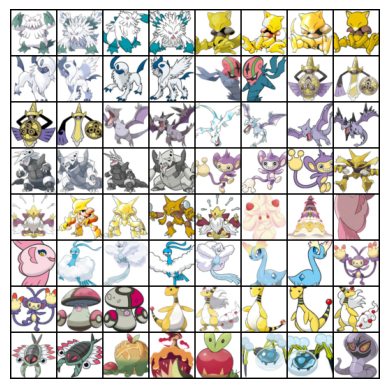

In [103]:
plt.axis('off')
plt.imshow(grid.permute(permute_mask))
plt.show()

### Реализация модели

In [104]:
def weights_init(m):
    global model_params

    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, model_params['w_stdev'])

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, model_params['w_stdev'])
        nn.init.constant_(m.bias.data, 0)

Применил основываясь на https://github.com/soumith/ganhacks:
- LeakyReLU вместо ReLU

In [164]:
class PokeGenerator(nn.Module):
    def __init__(self, mp):
        super(PokeGenerator, self).__init__()

        self.extender = nn.Sequential(*[
            nn.ConvTranspose2d(
                in_channels=mp['latent_sz'],
                out_channels=mp['generator_fm'] * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(mp['generator_fm'] * 8),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                in_channels=mp['generator_fm'] * 8,
                out_channels=mp['generator_fm'] * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(mp['generator_fm'] * 4),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                in_channels=mp['generator_fm'] * 4,
                out_channels=mp['generator_fm'] * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(mp['generator_fm'] * 2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                in_channels=mp['generator_fm'] * 2,
                out_channels=mp['generator_fm'],
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(mp['generator_fm']),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                in_channels=mp['generator_fm'],
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
        ])

    def forward(self, Z):
        return self.extender(Z)

generator = PokeGenerator(model_params)
generator

PokeGenerator(
  (extender): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2,

In [157]:
Z = torch.randn(64, 100, 1, 1)
generator(Z).shape

torch.Size([64, 64, 32, 32])